In [1]:
%matplotlib inline
%pip freeze > requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg import (
    HeisenbergModel,
    get_n_steps,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
    extract_probs,
)
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import mthree
import pickle
import networkx as nx
from datetime import datetime, timezone
import json
import math

In [4]:
# Set up the Qiskit Runtime service (this is an one-time setup)
# QiskitRuntimeService.save_account(
#     token="YOUR_API_TOKEN",
#     channel="ibm_quantum",
# )

In [5]:
# Option1: Use IBM Quantum backend.
# Load saved credentials
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()

noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['x', 'measure', 'reset', 'id', 'cz', 'sx']>)


# データセット作成 $f(H) = e^{-\beta H}$

In [6]:
n_samples = 5
n_qubits = 20
beta = 1

# graph_type = "line"
# ghz_qubits = list(range(n_qubits // 2))
# ghz_qubits = list(range(0, n_qubits, 2))
# print(f"GHZ qubits: {ghz_qubits}")

## Create graph (Demo)

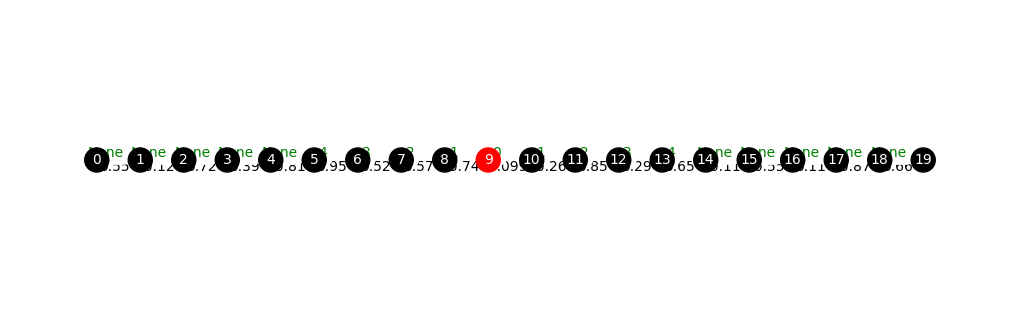

In [7]:
rng = np.random.default_rng(42)
G = get_graph(n_qubits, rng)

positions = get_positions(n_qubits)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

In [8]:
# State |0011...1100> (center qubits are 1 and the rest are 0)
leftmost = n_qubits // 4
rightmost = leftmost + n_qubits // 2 - 1
index = []
for i in range(n_qubits):
    if leftmost <= i <= rightmost:
        index.append("1")
    else:
        index.append("0")

index = "".join(index)
print(f"binary index: {index}")
state = Statevector.from_label(index)

print(f"decimal: {int(index, 2)}")
print(state[int(index, 2)])

binary index: 00000111111111100000
decimal: 32736
(1+0j)


## Non Trotter simulation (directly compute the expectation value)

In [9]:
data = []
graphs = []
rng = np.random.default_rng(42)

for i in range(n_samples):
    print(f"Sample {i}/{n_samples}")
    G = get_graph(n_qubits, rng)
    Js = [G.edges[edge]["J"] for edge in G.edges]
    heisenberg = HeisenbergModel(n_qubits, G)

    H = heisenberg.H

    # state is big endian, so we need to reverse the qubits of the Hamiltonian
    H = Operator(H).reverse_qargs().to_matrix()
    H = scipy.sparse.csr_matrix(H)
    norm = scipy.sparse.linalg.norm(H, ord=2)  # For debugging

    fH = scipy.sparse.linalg.expm(-beta * H)
    # Compute the expectation value <state|exp(-beta*H)|state>
    y = np.vdot(state, fH @ state).real

    data.append({"Js": Js, "expected_value": y, "norm": norm})
    graphs.append(G)

df = pd.DataFrame(data)
display(df)

: 

: 

: 

## Pre-process data

In [ ]:
df["expected_value"].describe()

count     56.000000
mean      14.008733
std       30.021335
min        0.229725
25%        1.369181
50%        2.868226
75%       12.082996
max      199.863057
Name: expected_value, dtype: float64

In [ ]:
df["norm"].describe()

count    56.000000
mean      6.260645
std       1.528530
min       3.319626
25%       5.188215
50%       6.125668
75%       7.251096
max      10.176261
Name: norm, dtype: float64

In [12]:
# # Query the 80% quantile
# q = df["expected_value"].quantile(0.8)
# filtered_index = df.query(f"expected_value < @q").index
# diffrence = df.index.difference(filtered_index)
# print(f"Outliers: {diffrence}")

# # Remove outliers
# df = df.drop(diffrence).reset_index(drop=True)
# graphs = [graph for i, graph in enumerate(graphs) if i not in diffrence]

Outliers: Index([0, 1, 3, 6, 13, 14, 24, 33, 43, 46, 53, 57, 59, 67], dtype='int64')


In [13]:
display(df)

n_samples = len(df)
print(f"Number of samples: {n_samples}")
df["expected_value"].describe()

,Js,expected_value,norm
0,"[0.5222794039807059, 0.5721286105539076, -0.74...",2.653082,2.959087
1,"[0.2877302401613291, 0.64552322654166, -0.1131...",0.865078,2.096133
2,"[-0.5455225564304462, 0.1091695740316696, -0.8...",1.138950,4.259728
3,"[-0.2909480637402633, 0.9413960487898065, 0.78...",4.367027,3.666207
4,"[0.5567669941475237, -0.6107225842960649, -0.0...",4.566077,2.099758
5,"[-0.9123924684255424, -0.6914210158649043, 0.3...",3.720380,3.561412
6,"[0.48952431181563427, 0.93501946486842, -0.348...",1.711405,3.218417
7,"[-0.25908058793026223, -0.06088837744838416, -...",0.920606,2.643683
8,"[-0.7401569893290567, -0.04859014754813251, -0...",1.084233,3.860418
9,"[0.6095287149936037, -0.22504324193965108, -0....",3.526609,2.297825


Number of samples: 56


count    56.000000
mean      2.248627
std       1.204008
min       0.527533
25%       1.295174
50%       2.026028
75%       2.779758
max       5.025722
Name: expected_value, dtype: float64

In [ ]:
df["norm"].describe()

count    56.000000
mean      2.802978
std       0.812152
min       1.164527
25%       2.098052
50%       2.790209
75%       3.360367
max       5.274069
Name: norm, dtype: float64

## Check eigvals and Configure params

In [10]:
n_features = 10  # Number of Fourier features

# Parameters for the Fourier feature generation
# For shifted Hamiltonian
# C = 20 * n_qubits  # upper bound for eigenvalues (WHY?)
# times = [2 * np.pi * k / C for k in range(n_features)]

# For unshifted Hamiltonian
# C = 10 * n_qubits  # upper bound for eigenvalues
# C = max(df["norm"]) * 10
C = max(df["norm"])
times = [np.pi * k / C for k in range(n_features)]

print(f"C: {C}")
print(f"times: {times}")

C: 10.795139821243238
times: [0.0, 0.29101917210999007, 0.5820383442199801, 0.8730575163299702, 1.1640766884399603, 1.4550958605499502, 1.7461150326599404, 2.0371342047699303, 2.3281533768799205, 2.6191725489899107]


In [11]:
# Only for using Docker container
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [12]:
CURRENT_TIME = (
    datetime.now(timezone.utc).isoformat(timespec="minutes").replace("+00:00", "Z")
)

path = f"./data/{CURRENT_TIME}"
os.makedirs(path, exist_ok=True)
print("Note: This CURRENT_TIME is used for other notebooks.")
print(f"CURRENT_TIME: {CURRENT_TIME}")
print(f"Saving data to {path}")

Note: This CURRENT_TIME is used for other notebooks.
CURRENT_TIME: 2025-01-15T02:55Z
Saving data to ./data/2025-01-15T02:55Z


In [13]:
# Save parameters

# Save the graphs as a binary file
with open(f"{path}/params_object.pkl", "wb") as f:
    pickle.dump(
        {
            "graphs": graphs,
            "Js": df["Js"].values,
            "expected_values": df["expected_value"].values,
        },
        f,
    )

# Save the parameters as a JSON file
with open(f"{path}/params_text.json", "w") as f:
    json.dump(
        {
            "n_samples": n_samples,
            "n_qubits": n_qubits,
            "backend_qpu_name": backend_qpu.name,
            "beta": beta,
            "C": C,
            "n_features": n_features,
            "times": times,
        },
        f,
        indent=4,
    )